In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Hidden states: 0 = Sunny, 1 = Cloudy, 2 = Rainy
states = ['Sunny', 'Cloudy', 'Rainy']
n_states = len(states)

# Simulate sequences of weather
state_sequence = np.random.choice(states, size=300, p=[0.4, 0.4, 0.2])

# Generate temperature and humidity based on weather state
obs = []
for state in state_sequence:
    if state == 'Sunny':
        temp = np.random.normal(30, 3)
        humidity = np.random.normal(40, 5)
    elif state == 'Cloudy':
        temp = np.random.normal(20, 3)
        humidity = np.random.normal(60, 5)
    elif state == 'Rainy':
        temp = np.random.normal(18, 2)
        humidity = np.random.normal(85, 5)
    obs.append([temp, humidity])

observations = np.array(obs)


In [2]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Encode true hidden states numerically
state_map = {s: i for i, s in enumerate(states)}
true_states = np.array([state_map[s] for s in state_sequence])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations)

# Train Continuous HMM
model_cont = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=42)
model_cont.fit(X_scaled)

# Predict hidden states
pred_states_cont = model_cont.predict(X_scaled)


In [3]:
from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn.hmm import MultinomialHMM

# Discretize temperature and humidity
kbin = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
obs_disc = kbin.fit_transform(observations).astype(int)

# Combine into single integers (e.g., [2,4] -> 2*5+4 = 14)
combined_obs = obs_disc[:, 0] * 5 + obs_disc[:, 1]
combined_obs = combined_obs.reshape(-1, 1)

# Train Discrete HMM
model_disc = MultinomialHMM(n_components=3, n_iter=1000, random_state=42)
model_disc.fit(combined_obs)

# Predict states
pred_states_disc = model_disc.predict(combined_obs)



MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


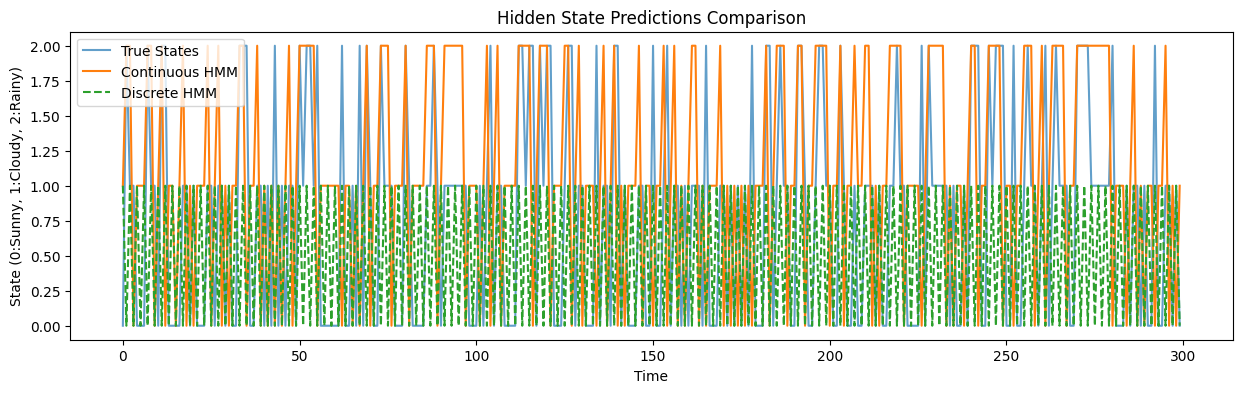

Continuous HMM Accuracy (aligned): 0.71
Discrete HMM Accuracy (aligned): 0.40


In [4]:
# Visualize State Sequences
plt.figure(figsize=(15, 4))
plt.plot(true_states, label='True States', alpha=0.7)
plt.plot(pred_states_cont, label='Continuous HMM')
plt.plot(pred_states_disc, label='Discrete HMM', linestyle='dashed')
plt.legend()
plt.title("Hidden State Predictions Comparison")
plt.xlabel("Time")
plt.ylabel("State (0:Sunny, 1:Cloudy, 2:Rainy)")
plt.show()

# Compare by clustering similarity (rough since true states aren't guaranteed to match)
def label_alignment_accuracy(true, predicted):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(true, predicted)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / np.sum(cm)

print(f"Continuous HMM Accuracy (aligned): {label_alignment_accuracy(true_states, pred_states_cont):.2f}")
print(f"Discrete HMM Accuracy (aligned): {label_alignment_accuracy(true_states, pred_states_disc):.2f}")
